# Part2. ga dataset 현황 분석(AS-IS 분석)

In [27]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import pickle
import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt
# plt.rc('font', family='NanumGothic')
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
from matplotlib import gridspec
%matplotlib inline

In [2]:
import pydata_google_auth
credentials = pydata_google_auth.get_user_credentials(
  ['https://www.googleapis.com/auth/bigquery'],
)

In [3]:
from google.cloud import bigquery
client = bigquery.Client (project = 'data-project-name' , credentials = credentials) 

### 2017년도 1분기 데이터 조회

In [4]:
query = """declare start_date string;
declare end_date string;

##원하는 날짜
set start_date = '170101';
set end_date = '170331';

with product_data as (
SELECT a.fullVisitorId
  , a.visitId
  , a.visitStartTime
  , pd.productSKU
  , pd.v2ProductName
  , pd.v2ProductCategory
  , pd.productVariant
  , pd.productPrice
  , pd.productListName
  , pd.productRefundAmount
  , case when pd.isImpression is null then 'e-commerce' else 'impression' end as isImpression
FROM  `bigquery-public-data.google_analytics_sample.ga_sessions_20*` as a,
UNNEST (a.hits) as hit_event,
UNNEST (hit_event.product) as pd
where 1 = 1
  and _table_suffix between start_date and end_date
)
,
device_info as (
select a.fullVisitorId
  , a.device.browser
  , a.device.deviceCategory
  , a.device.isMobile
  , a.device.operatingSystem
FROM  `bigquery-public-data.google_analytics_sample.ga_sessions_20*` as a
#, UNNEST (a.device) as de
where 1 = 1
  and a._table_suffix between start_date and end_date
)
, source_information as (
select a.fullVisitorId
  , a.visitId
  , a.date
  , a.trafficSource.campaign
  , a.trafficSource.Source
  , a.trafficSource.medium
  , a.trafficSource.keyword
  , a.channelGrouping
from `bigquery-public-data.google_analytics_sample.ga_sessions_20*` as a
#, unnest (a.trafficSource) as source
where 1= 1
  and a._table_suffix between start_date and end_date
 
)
#########


## 기초적으로 활용할 데이터 셋
select 
  ## 사용자가 어떻게 진입했는지 알려주는 정보
  t1.fullVisitorId
  , t1.visitId
  , CONCAT(t1.fullVisitorId, '_', t1.visitId) as SessionId
  , t1.date
  , t1.campaign
  , t1.Source
  , t1.medium
  , t1.keyword
  , t1.channelGrouping
  ## 기기의 정보
  , t2.browser
  , t2.deviceCategory
  , t2.isMobile
  , t2.operatingSystem
  ## 구매한 제품의 정보 
  , t3.productSKU
  , t3.v2ProductName
  , t3.v2ProductCategory
  , t3.productVariant
  , t3.productPrice
  , t3.productListName
  , t3.productRefundAmount
  , t3.isImpression
from source_information as t1
join device_info as t2 on t1.fullVisitorId = t2.fullVisitorId
join product_data as t3 on t1.fullVisitorId = t3.fullVisitorId
                          and t1.visitId = t3.visitId
"""

In [7]:
df_result = client.query (query) .to_dataframe ()

In [4]:
#df_result.to_pickle("../ga_sample_170101_170331.pkl")
df_result = pd.read_pickle("../ga_sample_170101_170331.pkl")

In [ ]:
df_result.shape

In [8]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8997769 entries, 0 to 8997768
Data columns (total 21 columns):
 #   Column               Dtype  
---  ------               -----  
 0   fullVisitorId        object 
 1   visitId              int64  
 2   SessionId            object 
 3   date                 object 
 4   campaign             object 
 5   Source               object 
 6   medium               object 
 7   keyword              object 
 8   channelGrouping      object 
 9   browser              object 
 10  deviceCategory       object 
 11  isMobile             bool   
 12  operatingSystem      object 
 13  productSKU           object 
 14  v2ProductName        object 
 15  v2ProductCategory    object 
 16  productVariant       object 
 17  productPrice         int64  
 18  productListName      object 
 19  productRefundAmount  float64
 20  isImpression         object 
dtypes: bool(1), float64(1), int64(2), object(17)
memory usage: 1.3+ GB


## 1. Session ID를 기준으로 Weekly(주) 단위로 표시해서 시각화하여, Traffic Trend를 파악합니다.

In [10]:
import gc
ga_data = df_result.copy()
del df_result
gc.collect()

6862

In [4]:
ga_data = pd.read_pickle("../ga_sample_170101_170331.pkl")

In [20]:
ga_data.iloc[10]

fullVisitorId                     991084272507288397
visitId                                   1486965047
SessionId              991084272507288397_1486965047
date                                        20170212
campaign                                   (not set)
Source                                   youtube.com
medium                                      referral
keyword                                         None
channelGrouping                               Social
browser                                        Opera
deviceCategory                               desktop
isMobile                                       False
operatingSystem                              Windows
productSKU                            GGOEYHPB072210
v2ProductName                      YouTube Twill Cap
v2ProductCategory        Home/Shop by Brand/YouTube/
productVariant                             (not set)
productPrice                                10990000
productListName                             Ca

In [12]:
print(ga_data['channelGrouping'].unique())
print('===========================')
print(ga_data['channelGrouping'].value_counts())

['Social' 'Organic Search' 'Referral' 'Affiliates' 'Direct' 'Paid Search'
 'Display' '(Other)']
Organic Search    4412387
Referral          1879379
Direct            1615568
Social             399414
Paid Search        360290
Display            260486
Affiliates          70161
(Other)                84
Name: channelGrouping, dtype: int64


- (Other)라는 채널그룹이 확인되는데, 이는 "GA에서 일반적으로 사용되는 매체명이 사용되지 않는 경우 기본 채널 그룹이 (Other)로 표시됩니다."

 [other정보출처](https://analyticsmarketing.co.kr/digital-analytics/google-analytics-basics/2430/)

In [23]:
# other 채널그룹의 세부정보를 확인해봅니다.
ga_data.loc[ga_data['channelGrouping']=='(Other)', ['Source','medium','campaign']].sample(n=10)

,Source,medium,campaign
7790999,Partners,(not set),(not set)
7805796,Partners,(not set),(not set)
7798791,Partners,(not set),(not set)
7822060,Partners,(not set),(not set)
7823442,Partners,(not set),(not set)
7798792,Partners,(not set),(not set)
7823447,Partners,(not set),(not set)
7805799,Partners,(not set),(not set)
7823444,Partners,(not set),(not set)
7822053,Partners,(not set),(not set)


In [25]:
print(ga_data.loc[ga_data['channelGrouping']=='(Other)','Source'].unique())
print(ga_data.loc[ga_data['channelGrouping']=='(Other)','medium'].unique())
print(ga_data.loc[ga_data['channelGrouping']=='(Other)','campaign'].unique())

['Partners']
['(not set)']
['(not set)']


In [13]:
ga_data['channelGrouping'].value_counts()

Organic Search    4412387
Referral          1879379
Direct            1615568
Social             399414
Paid Search        360290
Display            260486
Affiliates          70161
(Other)                84
Name: channelGrouping, dtype: int64

In [14]:
# 내부/외부 유입 설정
ga_data['FunnelType'] = 'external'
ga_data.loc[ga_data['channelGrouping'].isin(['Direct','Organic Search']), 'FunnelType'] = 'internal'

In [15]:
# week_num표시
ga_data['week_num'] = ga_data['date'].apply(lambda x: datetime.strptime(x,'%Y%m%d').isocalendar()[1])

In [45]:
pd.pivot_table(ga_data.reset_index(),index='week_num', columns='FunnelType', values='SessionId', aggfunc='nunique')

FunnelType,external,internal
week_num,,
1,6026,1228
2,6272,1137
3,6191,1340
4,6797,2248
5,6782,1331
6,7404,1197
7,7660,2000
8,7123,1452
9,7027,1318


In [16]:
ga_data.loc[ga_data['week_num'] == 52, 'date'].value_counts()

20170101    45263
Name: date, dtype: int64

In [17]:
# 2016년도 52주차가 되어버린 2017년도 1월 1일은 분석 대상에서 제외시킵니다.
ga_data = ga_data[ga_data['week_num'] != 52]

In [18]:
ga_data['week_num'].value_counts()

10    870122
7     852501
8     778016
9     763010
5     710578
6     679918
4     657477
11    649477
3     641899
12    637170
2     637104
1     586706
13    488528
Name: week_num, dtype: int64

In [19]:
# datetime으로 변경합니다. (주차별 시작 날짜를 알기 위해)
ga_data['date'] = ga_data['date'].astype('datetime64[ns]')

In [20]:
# 주차별 번호로 보면 날짜가 한번에 들어오지 않으니 주차별 시작 날짜를 기준으로 변경합니다.
week_frst_date_info = ga_data.groupby('week_num').agg({'date':'min'}).rename(columns = {'date':'week_frst_date'}).reset_index()

In [21]:
ga_data=pd.merge(ga_data, week_frst_date_info, on='week_num',how='left')

In [23]:
ga_data['date'] = ga_data['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [31]:
ga_data['week_frst_date'] = ga_data['week_frst_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [24]:
# merge 잘 되었는지, 결측치가 생기진 않았는지 확인
ga_data.isna().sum()

fullVisitorId                0
visitId                      0
SessionId                    0
date                         0
campaign                     0
Source                       0
medium                       0
keyword                6245705
channelGrouping              0
browser                      0
deviceCategory               0
isMobile                     0
operatingSystem              0
productSKU                   0
v2ProductName                0
v2ProductCategory            0
productVariant               0
productPrice                 0
productListName              0
productRefundAmount    8952506
isImpression                 0
FunnelType                   0
week_num                     0
week_frst_date               0
dtype: int64

CPU times: user 4.68 s, sys: 3.84 s, total: 8.52 s
Wall time: 11.3 s


Text(0, 0.5, 'Session Count (Unique)')

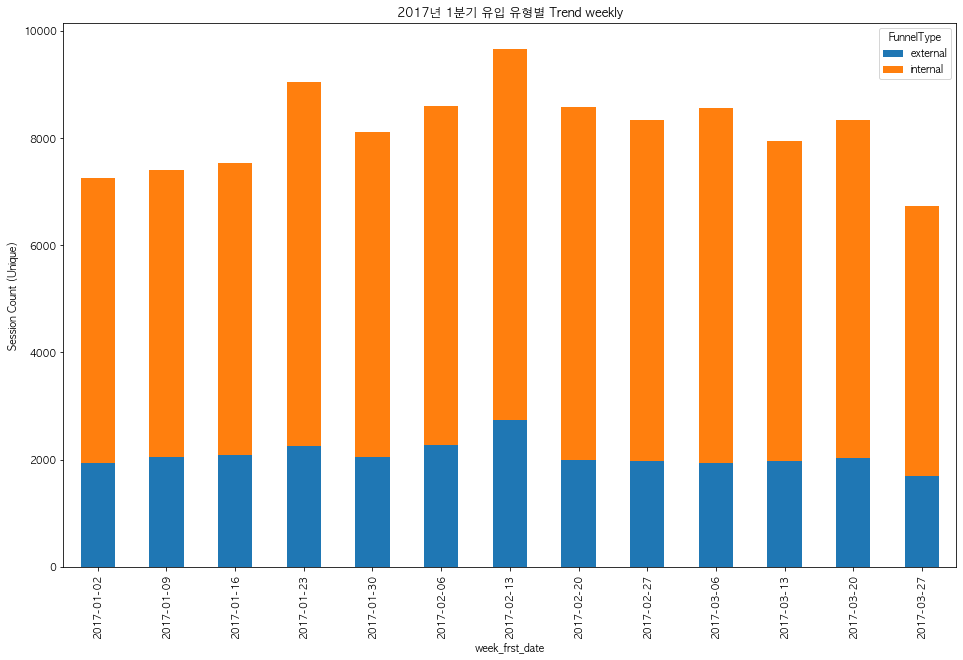

In [32]:
#%%time
ax = pd.pivot_table(ga_data.reset_index(),index='week_frst_date', columns='FunnelType', values='SessionId', aggfunc='nunique')\
.plot(figsize=(16,10), legend=True, kind='bar', stacked=True)
ax.set_title('2017년 1분기 유입 유형별 Trend weekly')
ax.set_ylabel("Session Count (Unique)")

CPU times: user 4.43 s, sys: 2.95 s, total: 7.38 s
Wall time: 9.15 s


Text(0, 0.5, 'Session Count (Unique)')

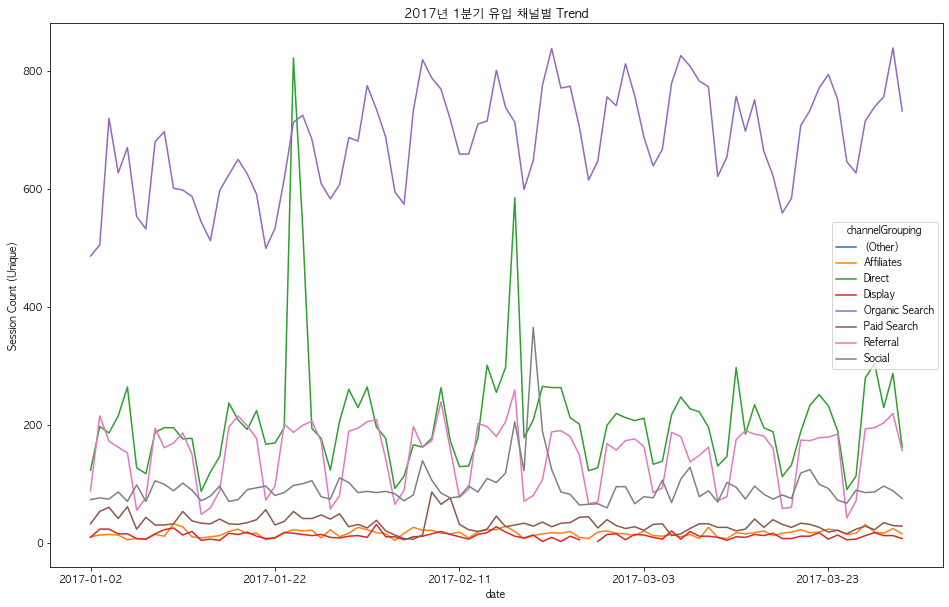

In [30]:
#%%time
ax1 = pd.pivot_table(ga_data.reset_index(),index='date', columns='channelGrouping', values='SessionId', aggfunc='nunique')\
.plot(figsize=(16,10), legend=True)
ax1.set_title('2017년 1분기 유입 채널별 Trend')
ax1.set_ylabel("Session Count (Unique)")

## 2. Session ID를 기준으로 시각화하여 제품(카테고리 and 상세제품)별로 무엇이 잘 팔리는지 확인
- part1에 이어, Apparel 카테고리 중심으로 확인해보았습니다.
- 다만, part1에서는 카테고리의 전처리과정없이 있는 그대로를 보았다면, 이번에는 Apparel 카테고리를 재분류하여 다뤄보았습니다.

In [18]:
#ga_data['date'] = ga_data['date'].astype('')
ga_data['month'] = ga_data['date'].apply(lambda x: x.month)

In [18]:
ga_data.columns

Index(['fullVisitorId', 'visitId', 'SessionId', 'date', 'campaign', 'Source',
       'medium', 'keyword', 'channelGrouping', 'browser', 'deviceCategory',
       'isMobile', 'operatingSystem', 'productSKU', 'v2ProductName',
       'v2ProductCategory', 'productVariant', 'productPrice',
       'productListName', 'productRefundAmount', 'isImpression', 'FunnelType',
       'week_num', 'week_frst_date'],
      dtype='object')

In [22]:
# 카테고리별 세션 횟수
cate_sessions = ga_data.groupby('v2ProductCategory').agg({'SessionId':'nunique'}).sort_values('SessionId',ascending=False)[:100]

In [28]:
print(ga_data.loc[ga_data['v2ProductCategory'] == '(not set)', 'Source'].value_counts())
print('====================================================')
print(ga_data.loc[ga_data['v2ProductCategory'] == '(not set)', 'medium'].value_counts())
print('====================================================')
print(ga_data.loc[ga_data['v2ProductCategory'] == '(not set)', 'campaign'].value_counts())
print('====================================================')
print(ga_data.loc[ga_data['v2ProductCategory'] == '(not set)', 'v2ProductName'].value_counts())

(direct)               508869
google                 248490
dfa                     29447
plus.google.com         15270
youtube.com             13351
                        ...  
kidrex.org                  3
spaces.google.com           3
images.google.de            3
m.vk.com                    3
au.search.yahoo.com         3
Name: Source, Length: 78, dtype: int64
(none)       508869
organic      236702
referral      56561
cpm           29447
cpc           14423
affiliate      5837
Name: medium, dtype: int64
(not set)                             832730
AW - Accessories                       10379
Data Share Promo                        5837
AW - Dynamic Search Ads Whole Site      2893
Name: campaign, dtype: int64
Google Men's Watershed Full Zip Hoodie Grey      28681
Google Men's Long Sleeve Raglan Ocean Blue       24658
Google Women's Short Sleeve Hero Tee Sky Blue    23900
Google Women's Lightweight Microfleece Jacket    22780
Google Women's 1/4 Zip Jacket Charcoal           20327


In [25]:
# 세션 횟수 TOP5  not set은 고려 대상에서 제외한다. (정보를 알 수 없으니 sales 혹은 마케팅에도 사용하기 힘들어보임)
cate_sessions[1:6]

,SessionId
v2ProductCategory,
Home/Shop by Brand/YouTube/,29173
Home/Apparel/Men's/Men's-T-Shirts/,13572
Home/Apparel/Men's/Men's-Outerwear/,11745
Home/Shop by Brand/Google/,9821
Home/Bags/Backpacks/,8523


In [31]:
[i for i in cate_sessions.index if i.find('Apparel') != -1]

["Home/Apparel/Men's/Men's-T-Shirts/",
 "Home/Apparel/Men's/Men's-Outerwear/",
 'Home/Apparel/',
 "Home/Apparel/Men's/",
 'Home/Apparel/Headgear/',
 "Home/Apparel/Women's/Women's-T-Shirts/",
 "Home/Apparel/Men's/Men's-Performance Wear/",
 "Home/Apparel/Women's/",
 "Home/Apparel/Women's/Women's-Outerwear/",
 'Apparel',
 "Home/Apparel/Women's/Women's-Performance Wear/",
 "Home/Apparel/Kid's/Kids-Youth/",
 "Home/Apparel/Kid's/Kid's-Infant/",
 "Home/Apparel/Kid's/Kid's-Toddler/",
 "Home/Apparel/Kid's/"]

In [33]:
ga_data_apparel = ga_data[ga_data['v2ProductCategory'].str.contains('Apparel')]

In [68]:
ga_data_apparel = ga_data_apparel.drop(columns = ['cateDepth1', 'cateDepth2', 'cateDepth3'])

In [69]:
# category depth를 만들어줍니다.

depth_dict = {0:'cateDepth1',1:'cateDepth2',2:'cateDepth3',3:'cateDepth4'}

for cate in tqdm(ga_data_apparel['v2ProductCategory'].unique()):
    for number in depth_dict.keys():
        try:
            ga_data_apparel.loc[ga_data_apparel['v2ProductCategory'] == cate, f'{depth_dict[number]}'] \
            = ga_data_apparel.loc[ga_data_apparel['v2ProductCategory'] == cate, 'v2ProductCategory']\
            .apply(lambda x: x[:-1].split('/')[number] if x[-1] == '/' else x.split('/')[number])
        except IndexError as e:
            print(f'{e}', 'cate: ', cate, 'number: ', number)
            continue

  7%|▋         | 1/15 [00:05<01:13,  5.28s/it]

list index out of range cate:  Home/Apparel/Headgear/ number:  3


 13%|█▎        | 2/15 [00:13<01:19,  6.12s/it]

list index out of range cate:  Home/Apparel/ number:  2


 20%|██        | 3/15 [00:17<01:05,  5.50s/it]

list index out of range cate:  Home/Apparel/ number:  3


 40%|████      | 6/15 [00:37<00:55,  6.15s/it]

list index out of range cate:  Apparel number:  1
list index out of range cate:  Apparel number:  2


 47%|████▋     | 7/15 [00:39<00:40,  5.05s/it]

list index out of range cate:  Apparel number:  3


 60%|██████    | 9/15 [00:50<00:31,  5.22s/it]

list index out of range cate:  Home/Apparel/Men's/ number:  3


 67%|██████▋   | 10/15 [00:54<00:23,  4.75s/it]

list index out of range cate:  Home/Apparel/Kid's/ number:  3


100%|██████████| 15/15 [01:18<00:00,  5.26s/it]

list index out of range cate:  Home/Apparel/Women's/ number:  3


In [70]:
ga_data_apparel[['cateDepth1', 'cateDepth2', 'cateDepth3','cateDepth4','v2ProductCategory']].sample(n=5)

,cateDepth1,cateDepth2,cateDepth3,cateDepth4,v2ProductCategory
1557720,Home,Apparel,NaN,NaN,Home/Apparel/
7943753,Home,Apparel,Men's,Men's-T-Shirts,Home/Apparel/Men's/Men's-T-Shirts/
806990,Home,Apparel,Kid's,Kid's-Infant,Home/Apparel/Kid's/Kid's-Infant/
3496656,Home,Apparel,Women's,NaN,Home/Apparel/Women's/
2507799,Home,Apparel,NaN,NaN,Home/Apparel/


- 큰 카테고리가 Home/Apparel 과  Apparel로 나뉘게 됩니다.
- 실제로 사이트를 들어가보았을 때, home을 거치지 않고 바로 Apparel로 가는 방법은 없는 것으로 확인되었습니다.
- 따라서, cateDepth1의 Home은 뎁스에서 제거하여, Apparel부터 뎁스가 시작되는 것으로 전처리하겠습니다.

In [71]:
print(ga_data_apparel['cateDepth1'].unique())
print(ga_data_apparel.loc[ga_data_apparel['cateDepth1'] == 'Apparel', 'cateDepth2'].unique())

['Home' 'Apparel']
[nan]


In [72]:
ga_data_apparel.loc[ga_data_apparel['cateDepth1'] == 'Apparel', 'cateDepth2'] = 'Apparel'
ga_data_apparel.drop(columns = 'cateDepth1',inplace=True)

In [73]:
ga_data_apparel = ga_data_apparel.rename(columns = {'cateDepth2':'cateDepth1'})

In [74]:
ga_data_apparel = ga_data_apparel.rename(columns = {'cateDepth3':'cateDepth2'})
ga_data_apparel = ga_data_apparel.rename(columns = {'cateDepth4':'cateDepth3'})

In [75]:
ga_data_apparel[['cateDepth1', 'cateDepth2', 'cateDepth3','v2ProductCategory']].sample(n=5)

,cateDepth1,cateDepth2,cateDepth3,v2ProductCategory
8610226,Apparel,Headgear,NaN,Home/Apparel/Headgear/
2883933,Apparel,Women's,Women's-Performance Wear,Home/Apparel/Women's/Women's-Performance Wear/
5215034,Apparel,NaN,NaN,Apparel
3003129,Apparel,Men's,Men's-T-Shirts,Home/Apparel/Men's/Men's-T-Shirts/
7855593,Apparel,NaN,NaN,Home/Apparel/


In [4]:
# 데이터 중간저장
#ga_data_apparel.to_pickle('../ga_data_apparel_202201_202203.pkl')
ga_data_apparel = pd.read_pickle('../ga_data_apparel_202201_202203.pkl')

In [5]:
ga_data_apparel['cateDepth2'] = ga_data_apparel['cateDepth2'].fillna('cate_none')

In [6]:
ga_data_apparel['cateDepth2'].unique()

array(['Headgear', "Men's", 'cate_none', "Women's", "Kid's"], dtype=object)

In [7]:
apparel_sales_cnt = ga_data_apparel[ga_data_apparel['isImpression'] == 'e-commerce'].groupby('cateDepth2')\
.agg({'SessionId':'nunique'}).rename(columns = {'SessionId':'selling_cnt'})\
.sort_values('selling_cnt',ascending=False)
display(apparel_sales_cnt)

,selling_cnt
cateDepth2,
Men's,6186
cate_none,3037
Women's,1884
Headgear,1106
Kid's,1090


In [43]:
apparel_sales_cnt = apparel_sales_cnt.reset_index()

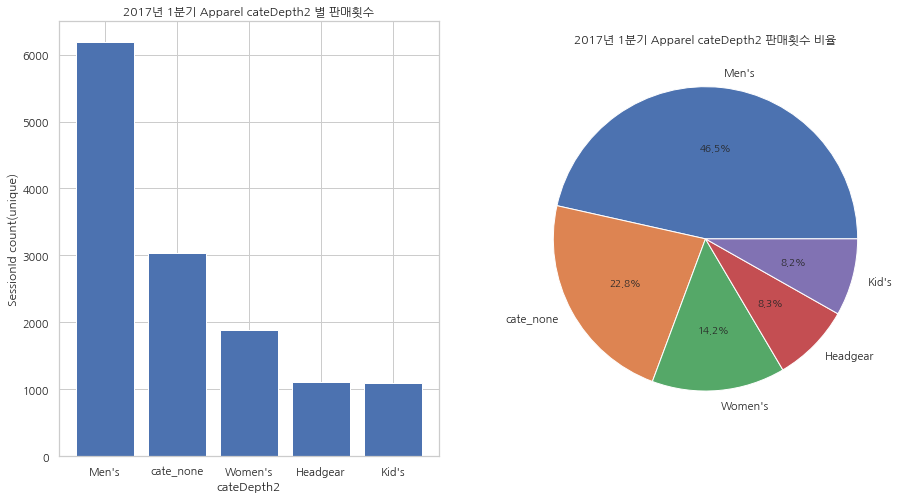

In [61]:
fig = plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 1])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

ax0.bar(apparel_sales_cnt["cateDepth2"],apparel_sales_cnt["selling_cnt"])
ax0.set_title('2017년 1분기 Apparel cateDepth2 별 판매횟수')
ax0.set_xlabel('cateDepth2')
ax0.set_ylabel('SessionId count(unique)')

ax1.pie(apparel_sales_cnt["selling_cnt"],labels=apparel_sales_cnt["cateDepth2"],autopct='%1.1f%%')
ax1.set_title('2017년 1분기 Apparel cateDepth2 판매횟수 비율')

plt.show()

- Apparel의 다음 뎁스를 기준으로 카테고리들의 판매 횟수를 시각화하였고, 위 그래프를 통해 "Men's" 에서 가장 제품이 많이 팔린 것을 알 수 있습니다.

Text(0, 0.5, 'Session Count (Unique)')

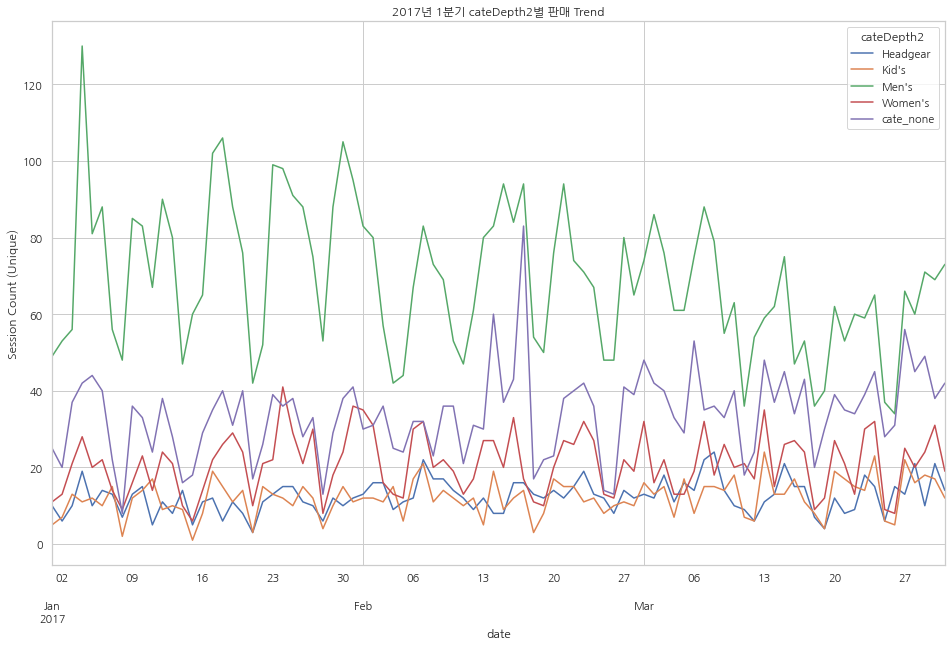

In [21]:
ax = pd.pivot_table(ga_data_apparel[ga_data_apparel['isImpression'] == 'e-commerce'].reset_index(),\
                     index='date', columns='cateDepth2', values='SessionId', aggfunc='nunique')\
.plot(figsize=(16,10), legend=True)
ax.set_title('2017년 1분기 cateDepth2별 판매 Trend')
ax.set_ylabel("Session Count (Unique)")

In [70]:
# 월별로도 보기
ga_data_apparel['month'] = ga_data_apparel['date'].apply(lambda x: x.month)

In [4]:
#ga_data_apparel.to_pickle('../ga_data_apparel_202201_202203.pkl')
ga_data_apparel = pd.read_pickle('../ga_data_apparel_202201_202203.pkl')

In [75]:
# 판매효율 확인.. (시각화 추가 필요)
ga_data_apparel.groupby(['cateDepth2','isImpression']).agg({'SessionId':'nunique'})\
.rename(columns = {'SessionId':'session_unique_cnt'})

session_unique_cnt
cateDepth2 isImpression                    
Headgear   e-commerce                  1106
           impression                  5104
Kid's      e-commerce                  1090
           impression                  3505
Men's      e-commerce                  6186
           impression                 27653
Women's    e-commerce                  1884
           impression                  8791
cate_none  e-commerce                  3037
           impression                  8025

In [ ]:
'''
'mens': 6 /33 -> 19% (구매전환..?)
'womens': 2/10 -> 20% 
'''

Text(0, 0.5, 'Session Count (Unique)')

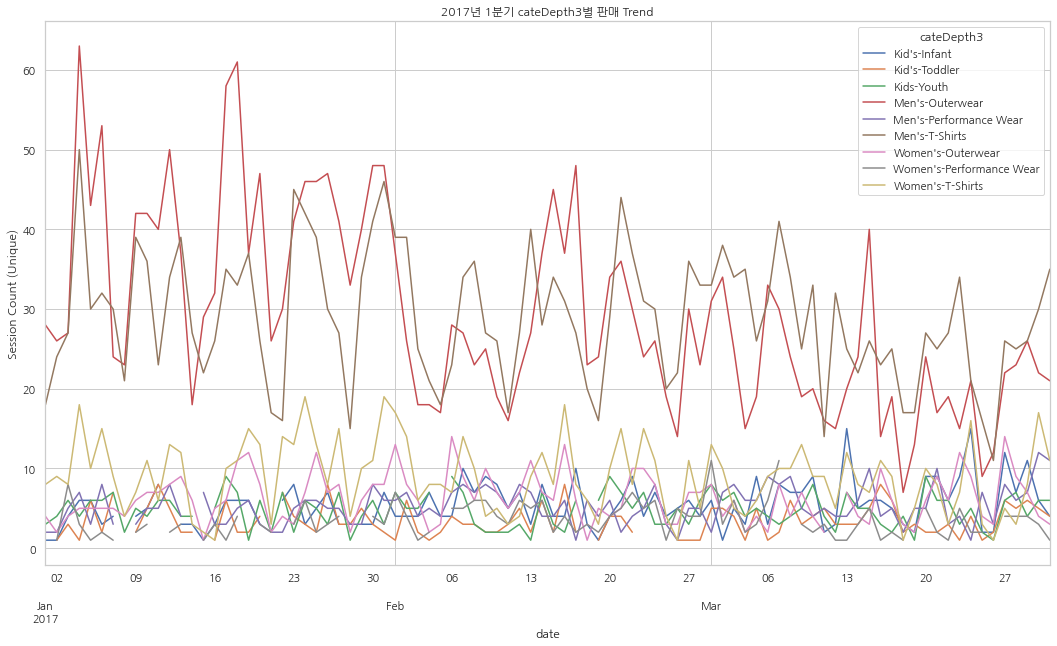

In [69]:
ax = pd.pivot_table(ga_data_apparel[ga_data_apparel['isImpression'] == 'e-commerce'].reset_index(),\
                     index='date', columns='cateDepth3', values='SessionId', aggfunc='nunique')\
.plot(figsize=(18,10), legend=True)
ax.set_title('2017년 1분기 cateDepth3별 판매 Trend')
ax.set_ylabel("Session Count (Unique)")

Text(0, 0.5, 'Session Count (Unique)')

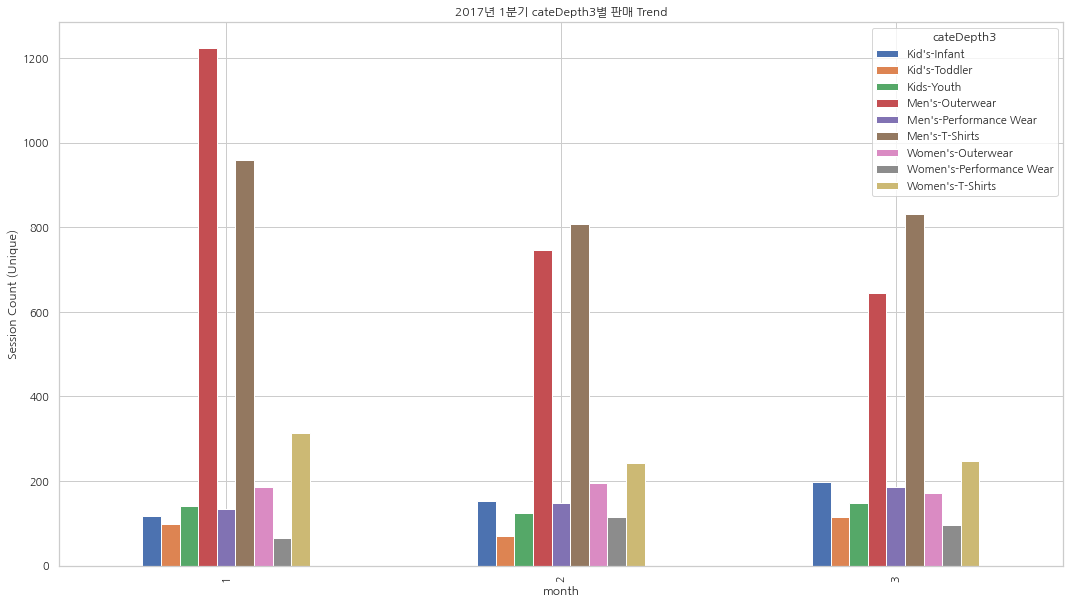

In [71]:
ax = pd.pivot_table(ga_data_apparel[ga_data_apparel['isImpression'] == 'e-commerce'].reset_index(),\
                     index='month', columns='cateDepth3', values='SessionId', aggfunc='nunique')\
.plot(kind='bar', figsize=(18,10), legend=True)
ax.set_title('2017년 1분기 cateDepth3별 판매 Trend')
ax.set_ylabel("Session Count (Unique)")

- Men's outwear는 판매횟수가 점점 줄어들지만, Women's outwear 판매에는 큰 변화가 없다.

Text(0, 0.5, 'Session Count (Unique)')

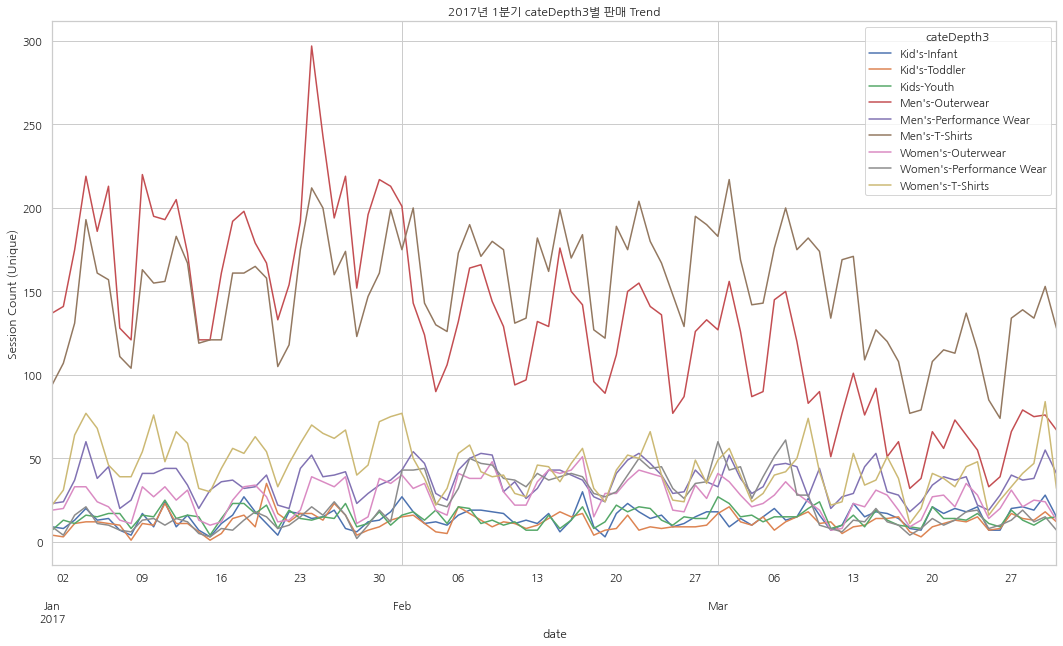

In [81]:
ax = pd.pivot_table(ga_data_apparel.reset_index(),\
                     index='date', columns='cateDepth3', values='SessionId', aggfunc='nunique')\
.plot(figsize=(18,10), legend=True)
ax.set_title('2017년 1분기 cateDepth3별 판매 Trend')
ax.set_ylabel("Session Count (Unique)")

판매의 46%를 차지하는 Mes's 카테고리를 좀 더 봐보았습니다.

In [78]:
#print(ga_data_apparel['cateDepth3'].unique())
ga_data_apparel.loc[(ga_data_apparel['isImpression'] == 'e-commerce')\
                    &(ga_data_apparel['cateDepth2'] == "Men's")].groupby('cateDepth3').agg({'SessionId':'nunique'})

,SessionId
cateDepth3,
Men's-Outerwear,2616
Men's-Performance Wear,466
Men's-T-Shirts,2597


## 3. 기기별로 Traffic Trend를 시각화여 트렌드 패턴과 특징 등을 파악합니다.

Text(0, 0.5, 'Session Count (Unique)')

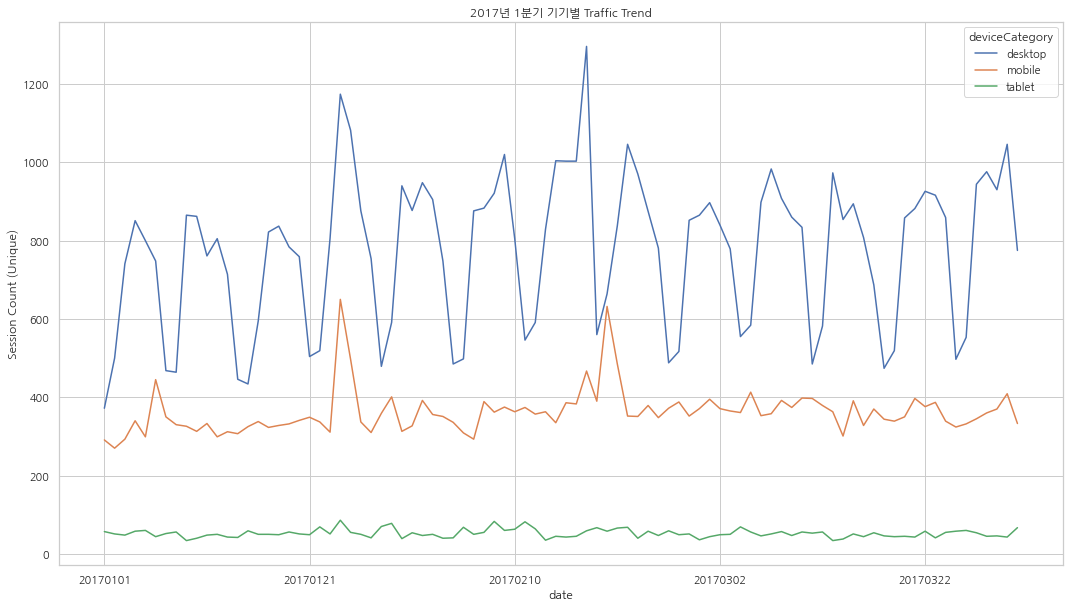

In [8]:
device_df = pd.pivot_table(ga_data.reset_index(),\
                     index='date', columns='deviceCategory', values='SessionId', aggfunc='nunique')
ax = device_df.plot(figsize=(18,10), legend=True)
ax.set_title('2017년 1분기 기기별 Traffic Trend')
ax.set_ylabel("Session Count (Unique)")

- 1월말에 desktop과 mobile에서 traffic이 전후대비 치솟는 현상이 보입니다.

Text(0, 0.5, 'Session Count (Unique)')

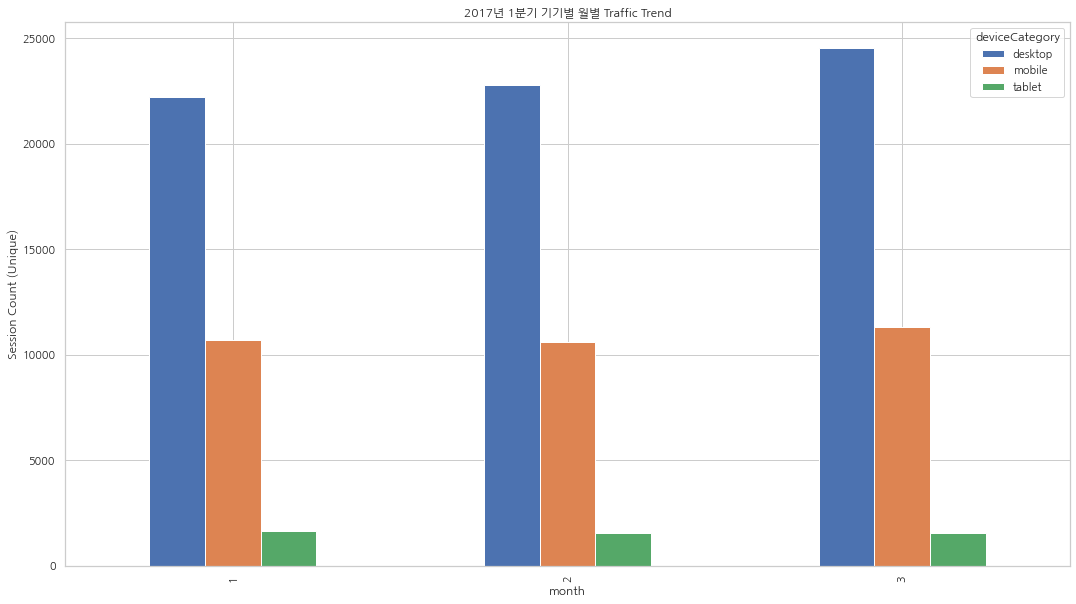

In [23]:
device_df = pd.pivot_table(ga_data.reset_index(),\
                     index='month', columns='deviceCategory', values='SessionId', aggfunc='nunique')
ax = device_df.plot(kind='bar', figsize=(18,10), legend=True)
ax.set_title('2017년 1분기 기기별 월별 Traffic Trend')
ax.set_ylabel("Session Count (Unique)")

- traffic trend를 월별로 보았을 때에는 그 규모가 일정한 편이고, 방문자의 기기 사용 비율도 일정한 편으로 보입니다.

Text(0, 0.5, 'Session Count (Unique)')

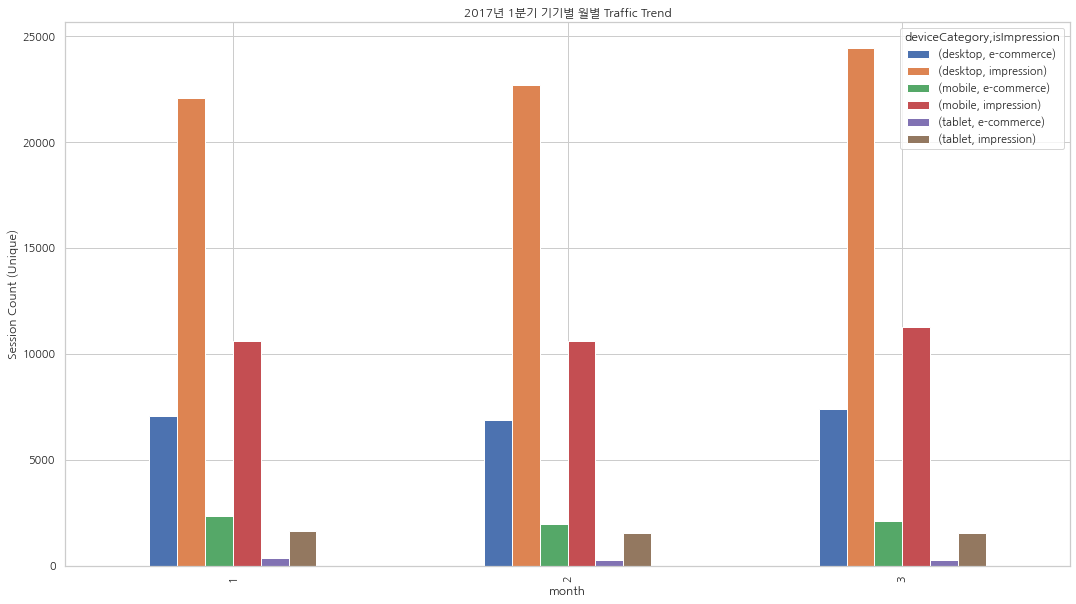

In [22]:
device_df = pd.pivot_table(ga_data.reset_index(),\
                     index='month', columns=['deviceCategory','isImpression'], values='SessionId', aggfunc='nunique')
ax = device_df.plot(kind='bar', figsize=(18,10), legend=True)
ax.set_title('2017년 1분기 기기별 월별 Traffic Trend')
ax.set_ylabel("Session Count (Unique)")

In [21]:
client.close()

## 4. Part3 을 위한 Build-Up : 가설 List Up 및 가설 검증 Plan의 제시

#### 가설 List Up
- 남성용 외투는 가을,겨울대비 봄,여름의 판매량이 적을 것이다.
- 여성용 외투는 판매량이 계절의 영향을 받지 않을 것이다.
- 다른 기기들보다 desktop에서의 구매전환율이 높을 것이다. -> 사용하는 기기가 구매전환율에 영향을 준다.
- 주말보다 평일에 구매가 많을 것이다.

#### 가설 검증 Plan
1. 남성용 외투는 가을,겨울대비 봄,여름의 판매량이 적을 것이다./ 여성용 외투는 판매량이 계절의 영향을 받지 않을 것이다.

    - 계절별로 기초 통계를 낸 데이터를 이용합니다.
    - 남성용/여성용 외투와 계절과의 상관분석/회귀분석을 실행합니다.
        - 상관분석: 피어슨 상관계수를 확인해봅니다. 상관관계가 있음이 확인되면 회귀분석도 실행해봅니다.
        - 회귀분석: 선형회귀분석 실행
        
2. 다른 기기들보다 desktop에서의 구매전환율이 높을 것이다. -> 사용하는 기기가 구매전환율에 영향을 준다.
    
    - 기기별로 전체기간 및 기간별 구매전환율(구매수/유입세션수)를 구합니다.
    - 분삭분석(ANOVA) 실행하여 기기들의 구매전환율 차이에 통계적 유의성이 있는지 확인합니다.
    - 유의성이 확인되었을 경우, 기기별로 구매전환율에 얼만큼의 차이가 있는지 확인합니다.
    
3. 주말보다 평일에 구매가 많을 것이다.
    - 주말과 평일이란 독립변수의 구매수에 관한 영향력의 정도를 확인하기 위한 회귀분석을 실행합니다.
    - T-test를 진행합니다.
    - p-value를 확인하여 두 집단간 차이의 통계적 유의성을 확인합니다.
    - 유의성이 확인되었을 경우, 주말과 평일의 구매수에 얼만큼의 차이가 있는지 확인합니다.